In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('../data/sierraleone-bumbuna.csv')

In [3]:
df.head(10)

Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-30 00:01 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.1  0.0     0.0   
1  2021-10-30 00:02 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2  2021-10-30 00:03 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
3  2021-10-30 00:04 -0.7  0.0 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   
4  2021-10-30 00:05 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   
5  2021-10-30 00:06 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   
6  2021-10-30 00:07 -0.7  0.0 -0.8   0.0   0.0  22.0  99.4  0.1     0.7   
7  2021-10-30 00:08 -0.7  0.0 -0.8   0.0   0.0  22.0  99.5  0.2     0.7   
8  2021-10-30 00:09 -0.7 -0.1 -0.8   0.0   0.0  22.0  99.5  0.7     1.1   
9  2021-10-30 00:10 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.6     1.1   

   WSstdev     WD  WDstdev    BP  Cleaning  Precipitation  TModA  TModB  \
0      0.0    0.0      0.0  1002         0            0.0   22.3   22.6   
1      0.0    0.0      0.0  1002         0            0.0   22.3   22.6   
2      0.0    0.0      0.0  1002         0            0.0   22.3   22.6   
3      0.0    0.0      0.0  1002         0            0.1   22.3   22.6   
4      0.0    0.0      0.0  1002         0            0.0   22.3   22.6   
5      0.0    0.0      0.0  1002         0            0.0   22.3   22.7   
6      0.2  240.4      0.0  1002         0            0.0   22.3   22.7   
7      0.4  233.5      1.6  1002         0            0.0   22.4   22.7   
8      0.5  232.0      0.3  1002         0            0.0   22.4   22.7   
9      0.5  232.5      0.3  1002         0            0.0   22.4   22.7   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  
6       NaN  
7       NaN  
8       NaN  
9       NaN

#### Summary Statistics & Missing-Value Report

In [4]:
print("Numeric columns' description: ")
print(df.describe().to_string())
print(f"\n{"-"*30}\n")

# print("Non-numeric/categorical columns' description: ")
# print(df.describe(include=["object"]).to_string())
# print(f"\n{"-"*30}\n")

print("Columns with null values: ")
print(df.isna().sum())
print(f"\n{"-"*30}\n")

# Identify columns with significant missing data (>5%)
# Calculate percentage of missing values for each column
missing_percentage = df.isna().mean() * 100
# Find columns with more than 5% missing values
columns_with_high_nulls = missing_percentage[missing_percentage > 5.0].index.tolist()

print("Columns with significant missing data (>5%): ")
print(columns_with_high_nulls)

Numeric columns' description: 
                 GHI            DNI            DHI           ModA           ModB           Tamb             RH             WS         WSgust        WSstdev             WD        WDstdev             BP       Cleaning  Precipitation          TModA          TModB  Comments
count  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000  525600.000000       0.0
mean      201.957515     116.376337     113.720571     206.643095     198.114691      26.319394      79.448857       1.146113       1.691606       0.363823     133.044668       7.172220     999.876469       0.000967       0.004806      32.504263      32.593091       NaN
std       298.495150     218.652659     158.946032     300.896893     288.889073       4.398605      20.520775       1.239248       1.617053       0.295000 

#### Outlier Detection & Basic Cleaning
**Target Columns**: `GHI`, `DNI`, `ModA`, `ModB`, `WS`, `WSgust`

We will perform the following steps on the specified columns:

0. **Convert data-types of entries of target columns to numeric**

1. **Handle Missing Values**
   - Identify missing values.
   - If the percentage of missing data is high, drop the column.
   - If the percentage is low, impute missing values using the median.

2. **Remove Incorrect Entries**
   - Check for negative values (which are physically implausible for these metrics).
   - Filter out rows containing such invalid entries.

3. **Remove Outliers**
   - Compute the z-score for each column.
   - Remove data points where `|z| > 3`, as they are considered statistical outliers.

In [5]:
# Create a copy of the dataframe for cleaning
df_clean = df.copy()

# 1. Handle missing values and non-numeric values
target_columns = ['GHI', 'DNI', 'ModA', 'ModB', 'WS', 'WSgust']

# Convert to numeric, setting invalid values to NaN
for col in target_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Check missing percentage for all columns
missing_percentage = df_clean.isna().mean() * 100
columns_with_high_nulls = missing_percentage[missing_percentage > 80].index.tolist()

print("Columns with >80% missing values:")
for col in columns_with_high_nulls:
    print(f"{col}: {missing_percentage[col]:.2f}%")

# Drop columns with high percentage of missing values
if columns_with_high_nulls:
    df_clean = df_clean.drop(columns=columns_with_high_nulls)
    print("\nDropped columns:", columns_with_high_nulls)

# 2. Remove Incorrect Entries
# Filter out physically implausible values (negative values for specified columns)
for col in target_columns:
    df_clean = df_clean[df_clean[col] >= 0]

# 3. Remove Outliers using Z-score method
def remove_outliers(df, columns, threshold=3):
    df_clean = df.copy()
    for col in columns:
        z_scores = np.abs(stats.zscore(df_clean[col]))
        df_clean = df_clean[z_scores < threshold]
    return df_clean

# Apply outlier removal to target columns
df_clean = remove_outliers(df_clean, target_columns)

# Print summary of data cleaning
print("\nOriginal dataset shape:", df.shape)
print("Cleaned dataset shape:", df_clean.shape)
print("\nRows removed:", df.shape[0] - df_clean.shape[0])
print("Percentage of data retained:", round((df_clean.shape[0] / df.shape[0]) * 100, 2), "%")

# Export cleaned DataFrame
output_path = '../data/sierraleone-bumbuna_clean.csv'
df_clean.to_csv(output_path, index=False)
print(f"Cleaned data exported to: {output_path}")

Columns with >80% missing values:
Comments: 100.00%

Dropped columns: ['Comments']

Original dataset shape: (525600, 19)
Cleaned dataset shape: (237808, 18)

Rows removed: 287792
Percentage of data retained: 45.25 %
Cleaned data exported to: ../data/sierraleone-bumbuna_clean.csv


#### Time Series Analysis
- Plot line/bar charts of `GHI`, `DNI`, `DHI`, `Tamb` vs. `Timestamp`.
- Look for:
  - Monthly seasonality
  - Daily trends
  - Anomalies (e.g., sudden peaks/drops in irradiance or temperature)

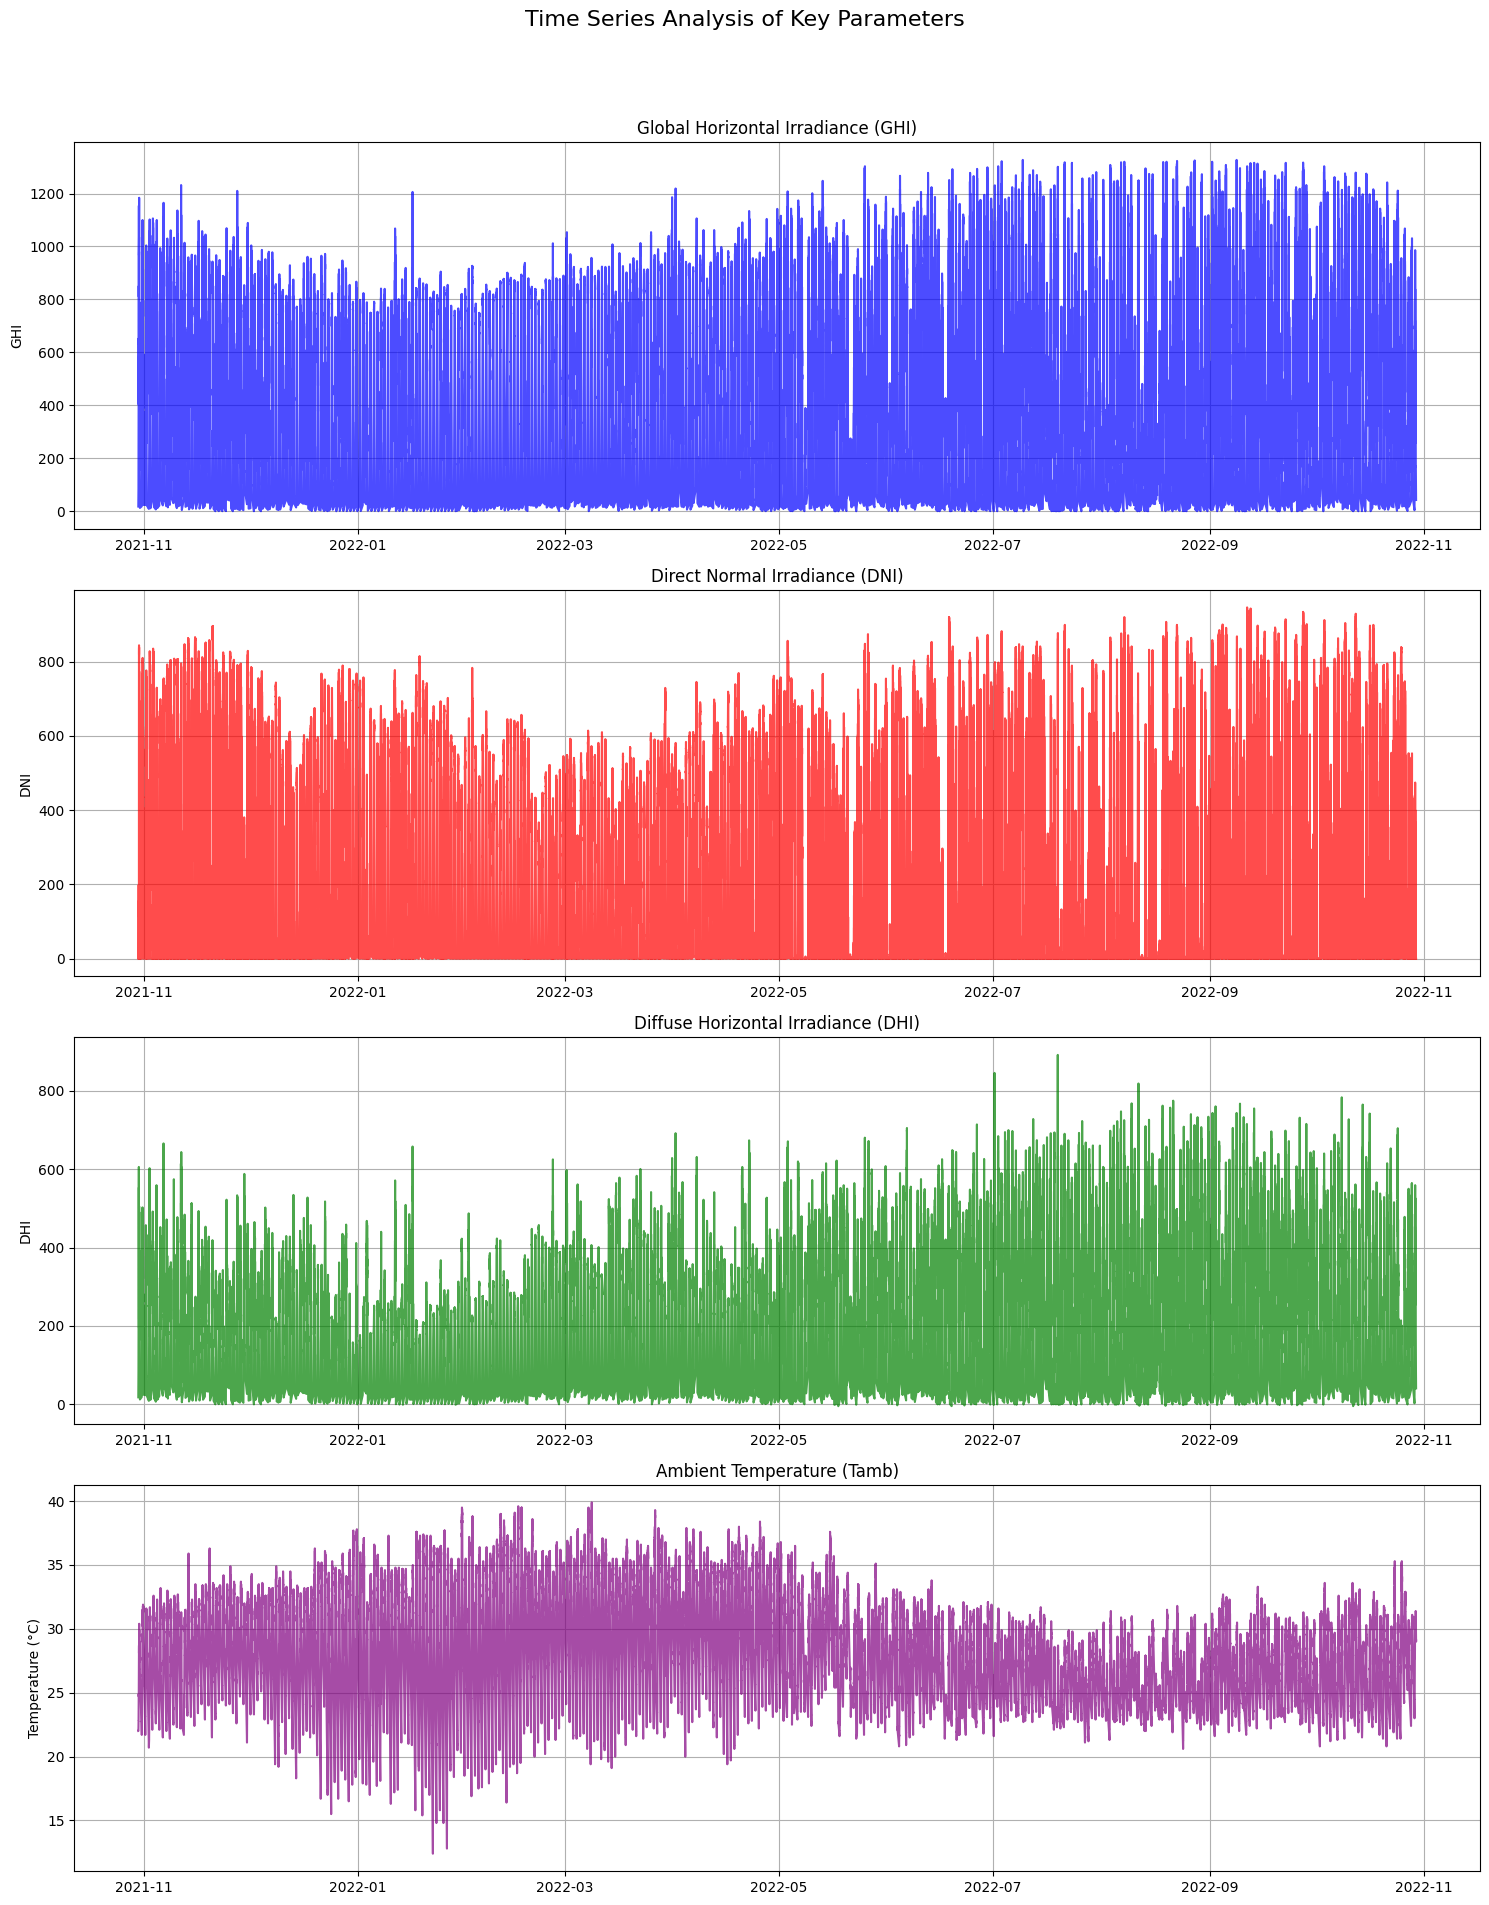

In [6]:
# Convert Timestamp to datetime format
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# Create subplots for the time series
fig, axes = plt.subplots(4, 1, figsize=(15, 20))
fig.suptitle('Time Series Analysis of Key Parameters', fontsize=16)

# Plot GHI
axes[0].plot(df_clean['Timestamp'], df_clean['GHI'], 'b-', alpha=0.7)
axes[0].set_title('Global Horizontal Irradiance (GHI)')
axes[0].set_ylabel('GHI')
axes[0].grid(True)

# Plot DNI
axes[1].plot(df_clean['Timestamp'], df_clean['DNI'], 'r-', alpha=0.7)
axes[1].set_title('Direct Normal Irradiance (DNI)')
axes[1].set_ylabel('DNI')
axes[1].grid(True)

# Plot DHI
axes[2].plot(df_clean['Timestamp'], df_clean['DHI'], 'g-', alpha=0.7)
axes[2].set_title('Diffuse Horizontal Irradiance (DHI)')
axes[2].set_ylabel('DHI')
axes[2].grid(True)

# Plot Tamb
axes[3].plot(df_clean['Timestamp'], df_clean['Tamb'], 'purple', alpha=0.7)
axes[3].set_title('Ambient Temperature (Tamb)')
axes[3].set_ylabel('Temperature (°C)')
axes[3].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Cleaning Impact
- Group data by a cleaning flag (e.g., pre/post-clean).
- Plot average values of `ModA` and `ModB` before and after cleaning.

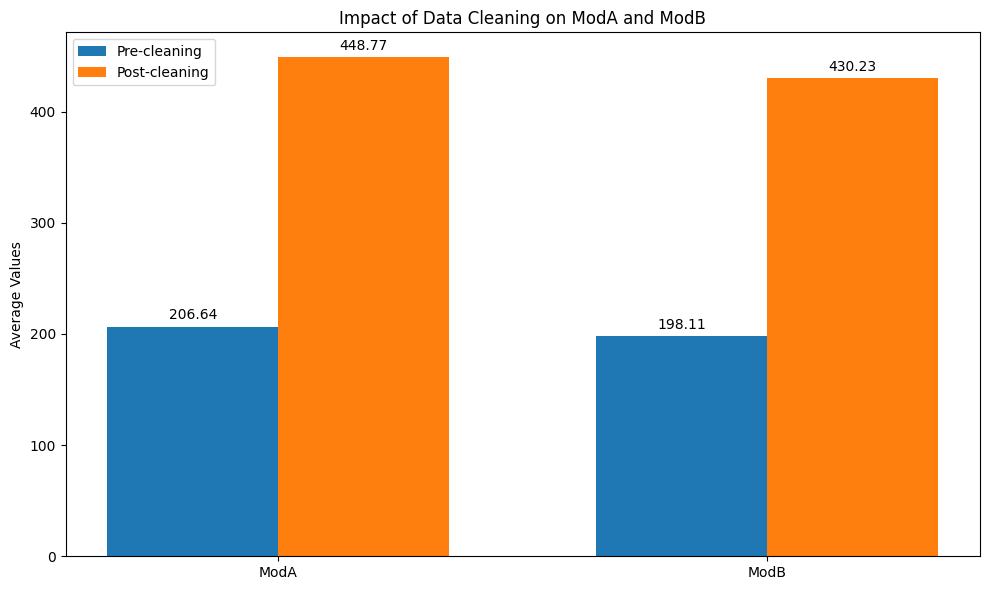

In [7]:
# Create comparison data
pre_clean = {
    'ModA': df['ModA'].mean(),
    'ModB': df['ModB'].mean()
}
post_clean = {
    'ModA': df_clean['ModA'].mean(),
    'ModB': df_clean['ModB'].mean()
}

# Set up the bar plot
labels = ['ModA', 'ModB']
pre_values = [pre_clean['ModA'], pre_clean['ModB']]
post_values = [post_clean['ModA'], post_clean['ModB']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, pre_values, width, label='Pre-cleaning')
rects2 = ax.bar(x + width/2, post_values, width, label='Post-cleaning')

# Add labels and title
ax.set_ylabel('Average Values')
ax.set_title('Impact of Data Cleaning on ModA and ModB')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Correlation & Relationship Analysis
- Generate a heatmap of correlations among:
  - `GHI`, `DNI`, `DHI`, `TModA`, `TModB`
- Create scatter plots for:
  - `WS`, `WSgust`, `WD` vs. `GHI`
  - `RH` vs. `Tamb`
  - `RH` vs. `GHI`

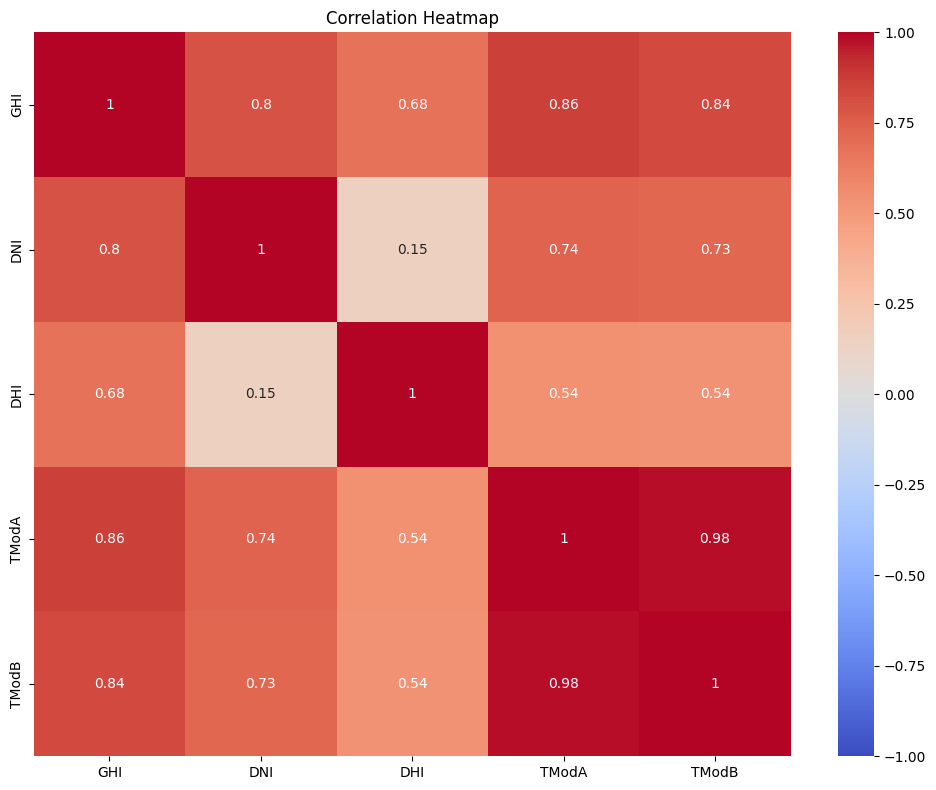

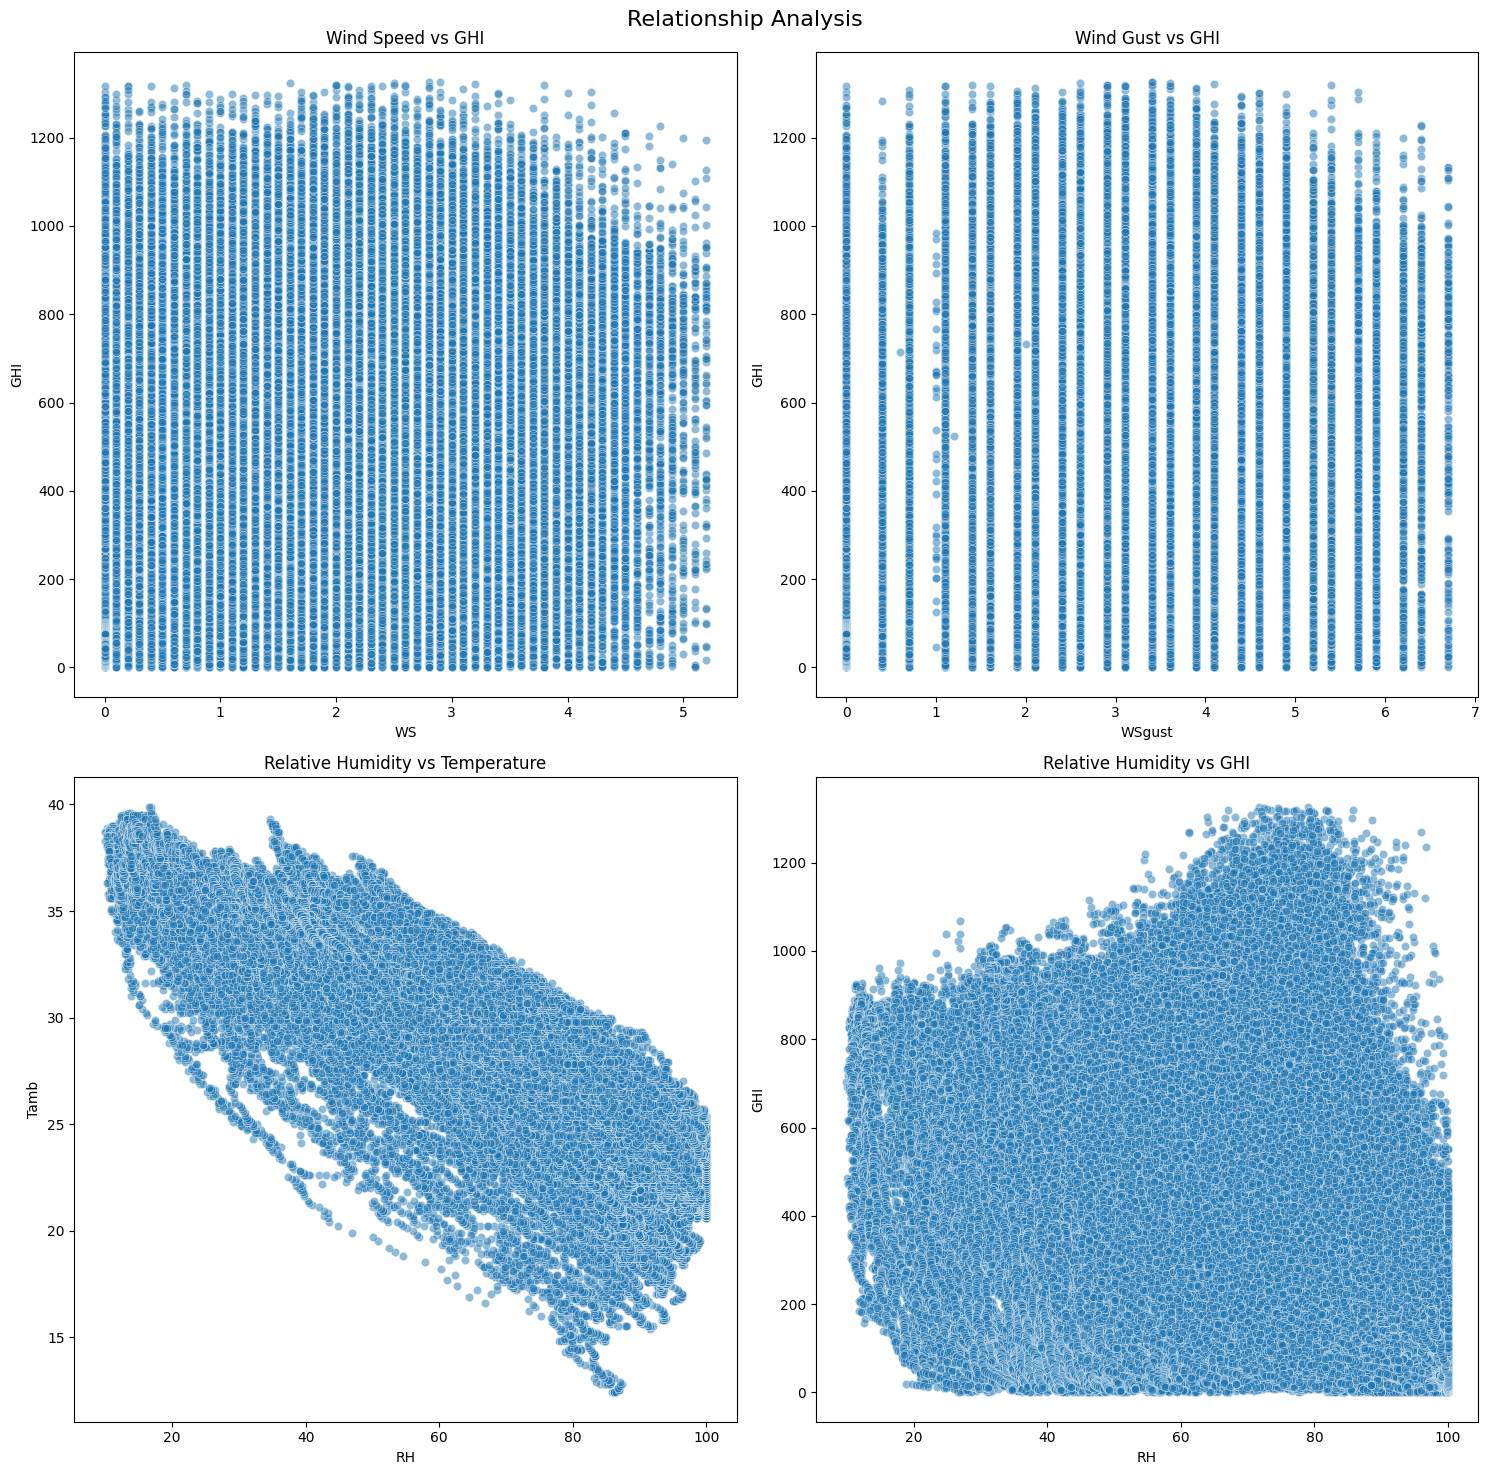

In [8]:
# Set up the figure for correlation heatmap
plt.figure(figsize=(10, 8))

# Create correlation matrix for specified columns
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
correlation_matrix = df_clean[corr_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Create scatter plots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Relationship Analysis', fontsize=16)

# Plot WS vs GHI
sns.scatterplot(data=df_clean, x='WS', y='GHI', alpha=0.5, ax=axes[0,0])
axes[0,0].set_title('Wind Speed vs GHI')

# Plot WSgust vs GHI
sns.scatterplot(data=df_clean, x='WSgust', y='GHI', alpha=0.5, ax=axes[0,1])
axes[0,1].set_title('Wind Gust vs GHI')

# Plot RH vs Tamb
sns.scatterplot(data=df_clean, x='RH', y='Tamb', alpha=0.5, ax=axes[1,0])
axes[1,0].set_title('Relative Humidity vs Temperature')

# Plot RH vs GHI
sns.scatterplot(data=df_clean, x='RH', y='GHI', alpha=0.5, ax=axes[1,1])
axes[1,1].set_title('Relative Humidity vs GHI')

plt.tight_layout()
plt.show()

#### Wind & Distribution Analysis
- Create wind rose or radial bar plots of `WS` and `WD`.
- Plot histograms for `GHI` and at least one other variable (e.g., `WS`).

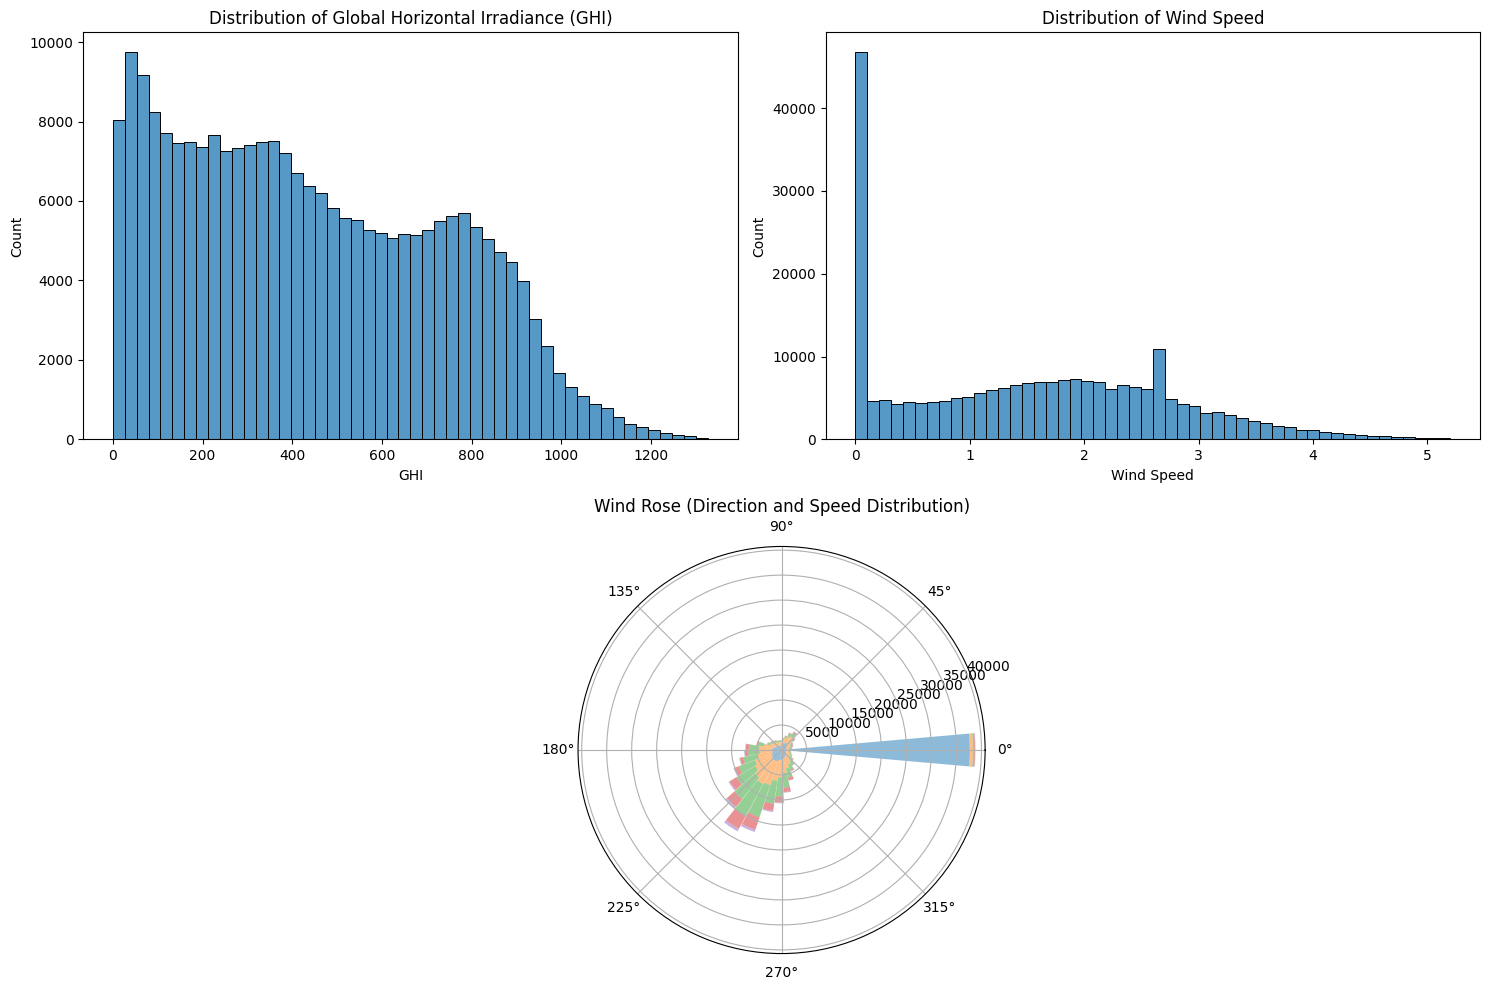

In [9]:
# Create figure with subplots
fig = plt.figure(figsize=(15, 10))

# Histogram for GHI
plt.subplot(2, 2, 1)
sns.histplot(data=df_clean, x='GHI', bins=50)
plt.title('Distribution of Global Horizontal Irradiance (GHI)')
plt.xlabel('GHI')
plt.ylabel('Count')

# Histogram for WS
plt.subplot(2, 2, 2)
sns.histplot(data=df_clean, x='WS', bins=50)
plt.title('Distribution of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Count')

# Wind Rose Plot
ax = plt.subplot(2, 2, (3,4), projection='polar')
bins = np.linspace(0, 360, 36)
ws_bins = np.linspace(0, df_clean['WS'].max(), 6)
hist, bin_edges = np.histogram(df_clean['WD'], bins=bins)
counts, wind_dirs, wind_speeds = np.histogram2d(
    df_clean['WD'], 
    df_clean['WS'],
    bins=[bins, ws_bins]
)

# Plot wind rose
theta = np.linspace(0, 2*np.pi, len(bins))
width = 2*np.pi/len(bins)
for i in range(len(ws_bins)-1):
    bars = ax.bar(
        np.deg2rad(bin_edges[:-1]),
        counts[:, i],
        width=width,
        bottom=counts[:, :i].sum(axis=1),
        alpha=0.5
    )

plt.title('Wind Rose (Direction and Speed Distribution)')
plt.tight_layout()
plt.show()

#### Temperature Analysis
- Investigate the effect of relative humidity (`RH`) on:
  - Ambient temperature (`Tamb`)
  - Solar radiation (`GHI`)

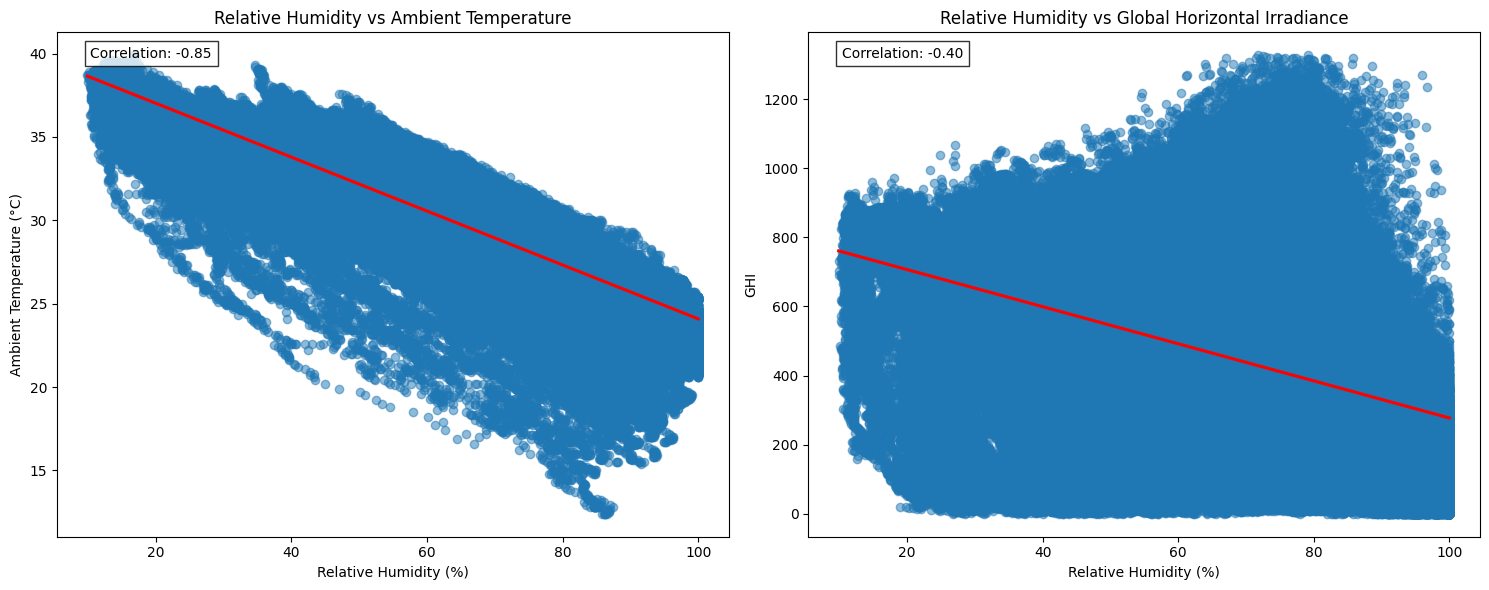

In [10]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: RH vs Tamb with regression line
sns.regplot(data=df_clean, x='RH', y='Tamb', ax=ax1, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
ax1.set_title('Relative Humidity vs Ambient Temperature')
ax1.set_xlabel('Relative Humidity (%)')
ax1.set_ylabel('Ambient Temperature (°C)')

# Add correlation coefficient for RH vs Tamb
corr_rh_tamb = df_clean['RH'].corr(df_clean['Tamb'])
ax1.text(0.05, 0.95, f'Correlation: {corr_rh_tamb:.2f}', 
         transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Plot 2: RH vs GHI with regression line
sns.regplot(data=df_clean, x='RH', y='GHI', ax=ax2, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
ax2.set_title('Relative Humidity vs Global Horizontal Irradiance')
ax2.set_xlabel('Relative Humidity (%)')
ax2.set_ylabel('GHI')

# Add correlation coefficient for RH vs GHI
corr_rh_ghi = df_clean['RH'].corr(df_clean['GHI'])
ax2.text(0.05, 0.95, f'Correlation: {corr_rh_ghi:.2f}', 
         transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

#### Bubble Chart
- Plot `GHI` vs. `Tamb` with:
  - Bubble size representing `RH` or `BP`

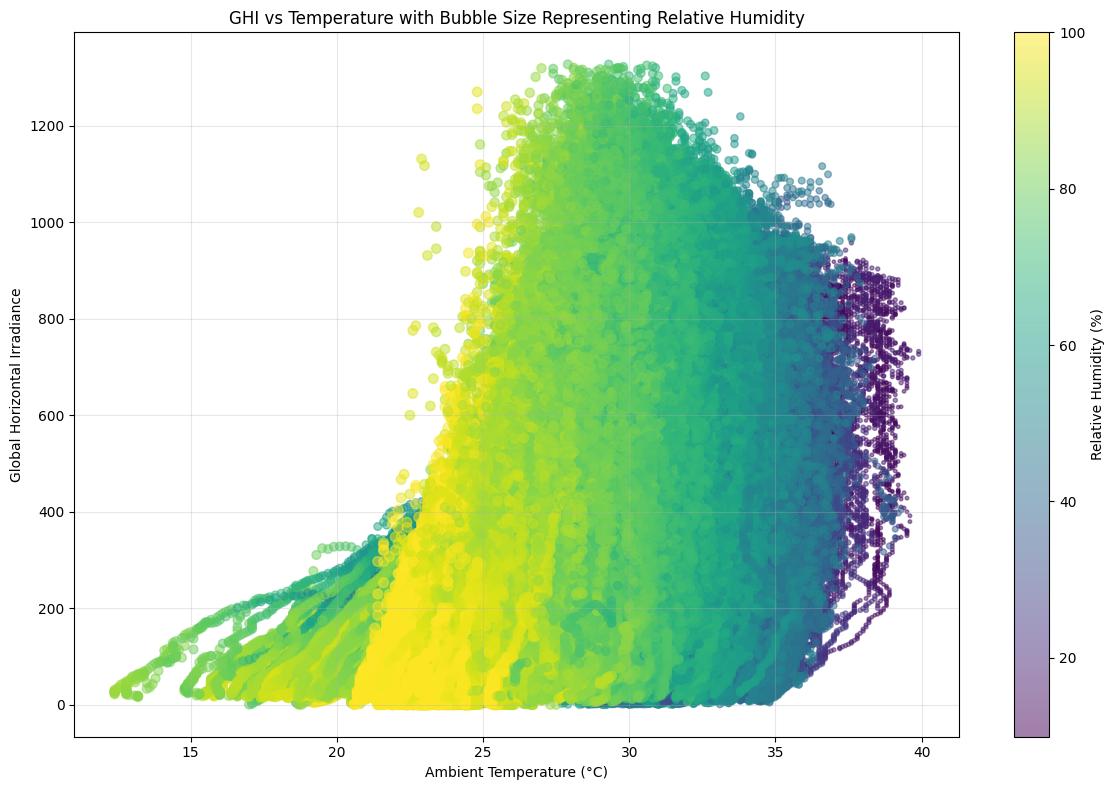

In [11]:
plt.figure(figsize=(12, 8))

# Create bubble chart
plt.scatter(df_clean['Tamb'], df_clean['GHI'], 
           s=df_clean['RH']/2,  # Divide by 2 to make bubbles smaller
           alpha=0.5,
           c=df_clean['RH'],    # Color bubbles by RH value
           cmap='viridis')

plt.colorbar(label='Relative Humidity (%)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Global Horizontal Irradiance')
plt.title('GHI vs Temperature with Bubble Size Representing Relative Humidity')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---